## Initialize imports, Polinomial Activation Layers and Cosine Data

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Best Model Arch so far n=4

Epoch 1/150


2023-10-05 16:42:56.233055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 16:42:56.249792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 16:42:56.249980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.5008 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4847 - val_loss: 0.4549
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1440 - val_loss: 0.0542
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0046
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 9.5232e-04
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 8.3653e-04
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 3.9938e-04 - val_loss: 3.4852e-04
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0023
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0011 - va

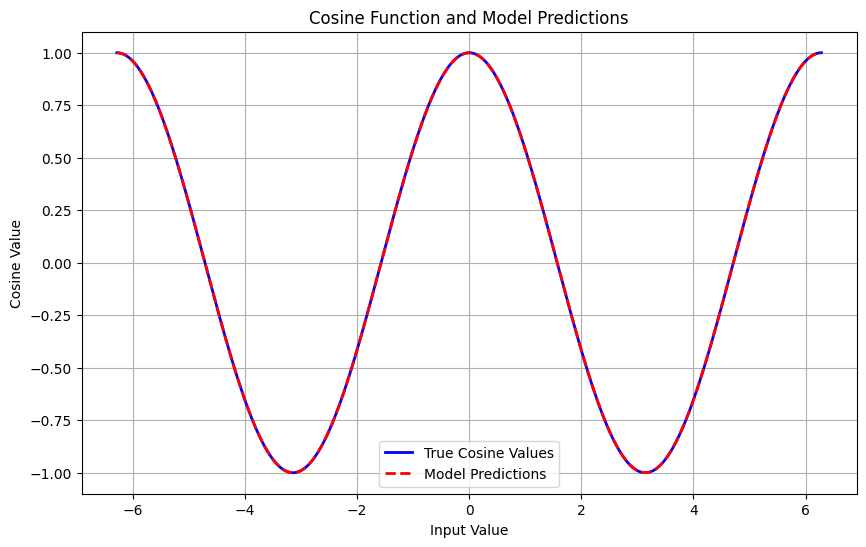

In [2]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



## Sequential Programmed model with Hermite activation

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


# Data generation
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi

X = np.arange(lower_bound, upper_bound, 0.001).reshape(-1, 1)
y = np.cos(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
rank = 3

# Define the custom activation functions
def hermite_h1(x):
    return 2 * x

def hermite_h2(x):
    return 4 * K.pow(x, 2) - 2

def hermite_h3(x):
    return 8 * K.pow(x, 3) - 12 * x

def hermite_h4(x):
    return 16 * K.pow(x, 4) - 48 * K.pow(x, 2) + 12

# Model definition

model = Sequential()
model.add(Dense(64, input_shape=(1,)))
model.add(Dense(64, activation=hermite_h1))
model.add(TensorDecompositionLayer(rank))
model.add(Dense(64, activation=hermite_h2))
model.add(TensorDecompositionLayer(rank))
model.add(Dense(64, activation=hermite_h3))
model.add(TensorDecompositionLayer(rank))
model.add(Dense(64, activation=hermite_h4))
model.add(TensorDecompositionLayer(rank))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32,callbacks=[callback])

# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")


Epoch 1/150


2023-10-31 13:37:58.343716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 13:37:58.357847: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc4784b5160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 13:37:58.357860: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-31 13:37:58.363115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 13:37:58.471587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 13:37:58.556003: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

315/315 [==============================] - 4s 4ms/step - loss: 0.2098 - val_loss: 0.0898
Epoch 2/150
315/315 [==============================] - 1s 4ms/step - loss: 0.0104 - val_loss: 0.0046
Epoch 3/150
315/315 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 4/150
315/315 [==============================] - 1s 4ms/step - loss: 0.0052 - val_loss: 0.0127
Epoch 5/150
315/315 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 6/150
315/315 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 3.5178e-05
Epoch 7/150
315/315 [==============================] - 1s 4ms/step - loss: 8.7774e-05 - val_loss: 3.8336e-04
Epoch 8/150
315/315 [==============================] - 1s 4ms/step - loss: 1.1196e-04 - val_loss: 1.4219e-05
Epoch 9/150
315/315 [==============================] - 1s 4ms/step - loss: 9.7843e-04 - val_loss: 0.0012
Epoch 10/150
315/315 [==============================] - 1s 4ms/step - loss: 0.3

32/32 [==============================] - 0s 1ms/step


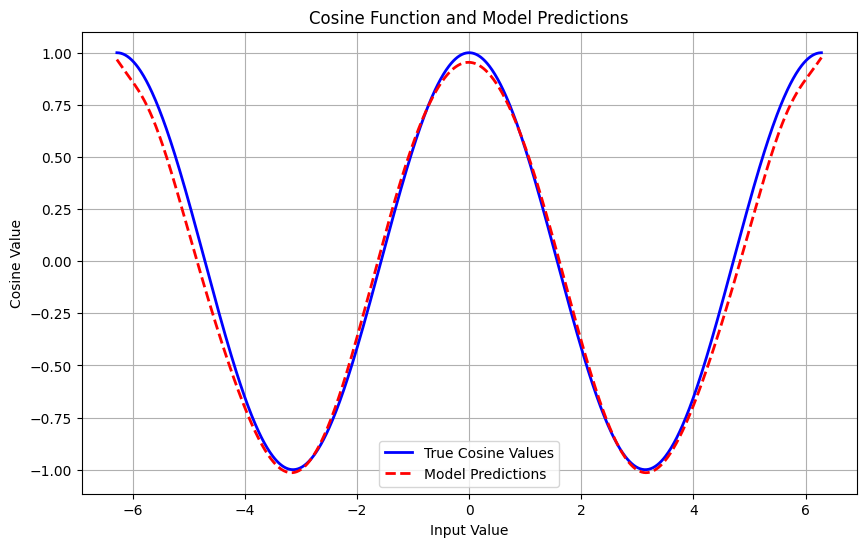

In [4]:


import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
 _1 (TensorDecompositionLay                                      
 er)                                                  

## N=4 model with Batch Normalization

2023-10-10 12:12:13.610669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/150


2023-10-10 12:12:13.626868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:12:13.627051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:12:13.628852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.1839 - val_loss: 4.2357
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0854 - val_loss: 0.7213
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0763 - val_loss: 1.3134
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.2466
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0995
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 1.1312
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.3546
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0293 - val_loss: 1.3486
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.5545
Epoch 10/150
125/125 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0446
E

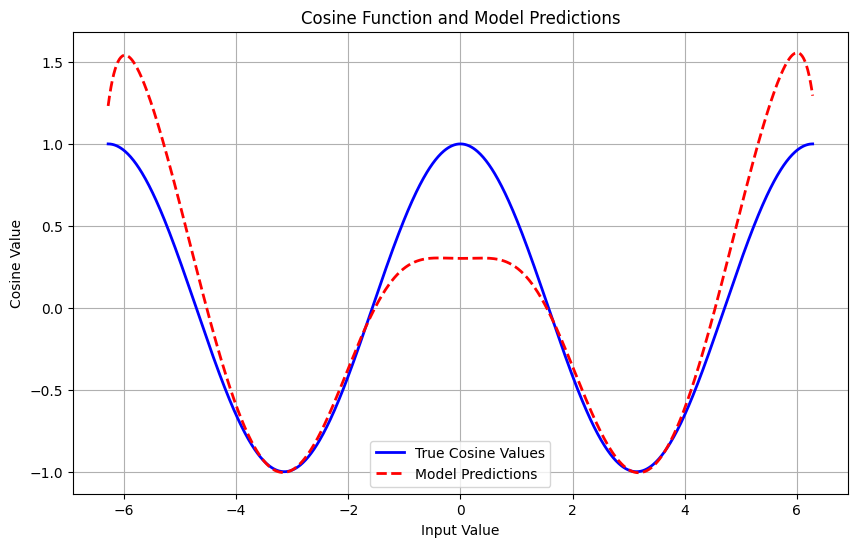

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    x = h3(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    x = h4(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)

    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelBatchNormal = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelBatchNormal.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150


history = modelBatchNormal.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelBatchNormal.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelBatchNormal.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



In [4]:
modelBatchNormal.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 h2_layer (H2Layer)          (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 h3_layer (H3Layer)          (None, 64)                64        
                                                             

# N = 5 With Batch Normalization

2023-10-10 12:13:53.383539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:13:53.402171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:13:53.402360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-10 12:13:55.912374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-10 12:13:55.914240: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2d29074a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 12:13:55.914252: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-10 12:13:55.917450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 12:13:56.024618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-10 12:13:56.113915: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 4s 6ms/step - loss: 0.6993 - val_loss: 235.4736
Epoch 2/150
125/125 [==============================] - 1s 5ms/step - loss: 0.3230 - val_loss: 0.4767
Epoch 3/150
125/125 [==============================] - 1s 4ms/step - loss: 0.3002 - val_loss: 0.4499
Epoch 4/150
125/125 [==============================] - 1s 4ms/step - loss: 0.2735 - val_loss: 0.3974
Epoch 5/150
125/125 [==============================] - 1s 5ms/step - loss: 0.2846 - val_loss: 2.2062
Epoch 6/150
125/125 [==============================] - 1s 4ms/step - loss: 0.1636 - val_loss: 0.4051
Epoch 7/150
125/125 [==============================] - 1s 4ms/step - loss: 0.1759 - val_loss: 0.3044
Epoch 8/150
125/125 [==============================] - 1s 4ms/step - loss: 0.1804 - val_loss: 1.4663
Epoch 9/150
125/125 [==============================] - 1s 4ms/step - loss: 0.1072 - val_loss: 0.3423
Epoch 10/150
125/125 [==============================] - 1s 5ms/step - loss: 0.0950 - val_loss: 0.6146

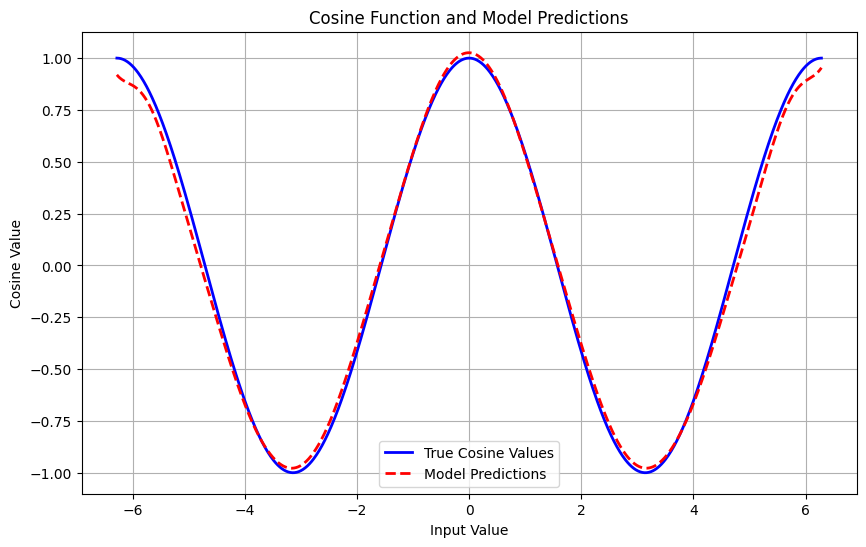

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    x = h3(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    x = h4(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    x = h5(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = BatchNormalization()(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modeln6_BatchNormal = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modeln6_BatchNormal.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150


history = modeln6_BatchNormal.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modeln6_BatchNormal.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modeln6_BatchNormal.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



## N = 5 With Tensor Decomposition

2023-10-10 12:15:53.203286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:15:53.221681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:15:53.222094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-10 12:15:55.590839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-10 12:15:55.604570: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f829cc4a740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 12:15:55.604587: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-10 12:15:55.609872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 12:15:55.720411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-10 12:15:55.802950: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 5ms/step - loss: 0.4974 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4937 - val_loss: 0.5167
Epoch 3/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4937 - val_loss: 0.5168
Epoch 4/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 5/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4938 - val_loss: 0.5166
Epoch 6/150
125/125 [==============================] - 0s 4ms/step - loss: 0.8725 - val_loss: 0.5163
Epoch 7/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4959 - val_loss: 0.5255
Epoch 8/150
125/125 [==============================] - 0s 4ms/step - loss: 0.5016 - val_loss: 0.5242
Epoch 9/150
125/125 [==============================] - 0s 4ms/step - loss: 0.5009 - val_loss: 0.5166
Epoch 10/150
125/125 [==============================] - 0s 4ms/step - loss: 0.4945 - val_loss: 0.5162
E

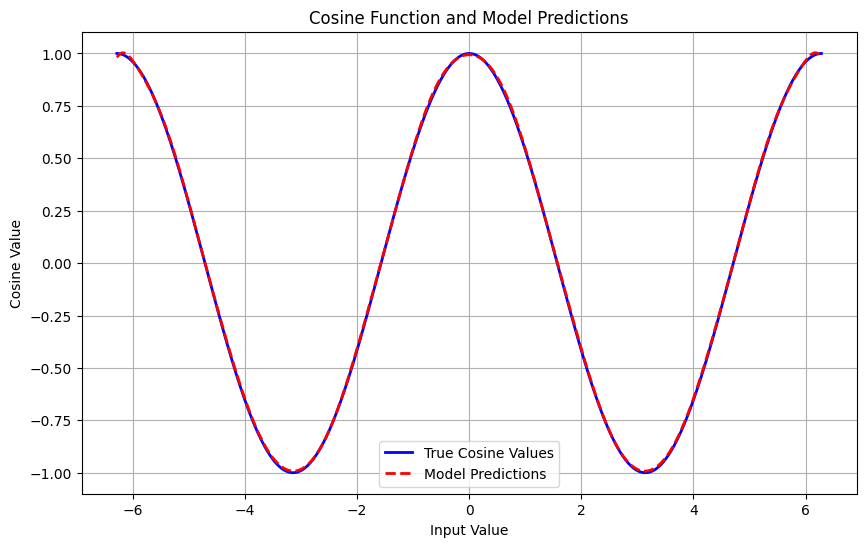

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    #x = BatchNormalization()(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    #x = BatchNormalization()(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    #x = BatchNormalization()(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    #x = BatchNormalization()(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modeln6_BatchNormal = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modeln6_BatchNormal.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150


history = modeln6_BatchNormal.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modeln6_BatchNormal.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modeln6_BatchNormal.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



# Bottle Neck Structure

2023-10-10 12:23:26.536080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:23:26.552857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 12:23:26.553048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-10 12:23:28.714954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-10 12:23:28.716298: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f54fe5e6ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 12:23:28.716310: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-10 12:23:28.719490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 12:23:28.825128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-10 12:23:28.913465: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.5030 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.3686 - val_loss: 0.0408
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0012
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 7.4113e-04 - val_loss: 3.2851e-04
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 6.5359e-04 - val_loss: 3.3355e-04
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.0058e-04
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 4.2039e-04 - val_loss: 9.2845e-04
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 8.3619e-04 - val_loss: 1.1406e-04
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 10/150
125/125 [==============================] - 0s 3ms/step

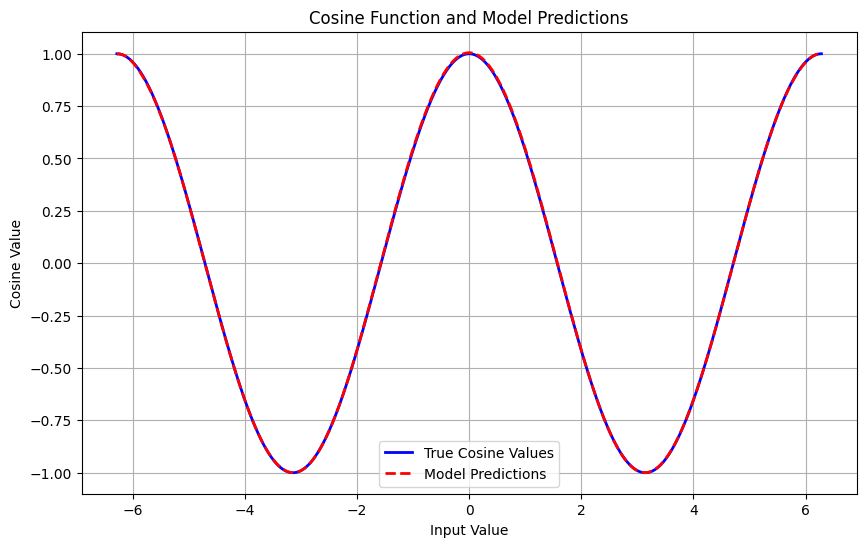

In [3]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(128)(x)
    x = h2(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 



input_shape = (1,)
filters = 64
model_bottleneck = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_bottleneck.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = model_bottleneck.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = model_bottleneck.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model_bottleneck.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



2023-10-05 14:18:06.253313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:18:06.270233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/150
125/125 [==============================] - 1s 3ms/step - loss: 0.5035 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4937 - val_loss: 0.5175
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4941 - val_loss: 0.5168
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4949 - val_loss: 0.5214
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4938 - val_loss: 0.5194
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4939 - val_loss: 0.5177
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4937 - val_loss: 0.5167
Epoch 8/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4944 - val_loss: 0.5205
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4951 - val_loss: 0.5189
Epoch 10/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4961 - val_lo

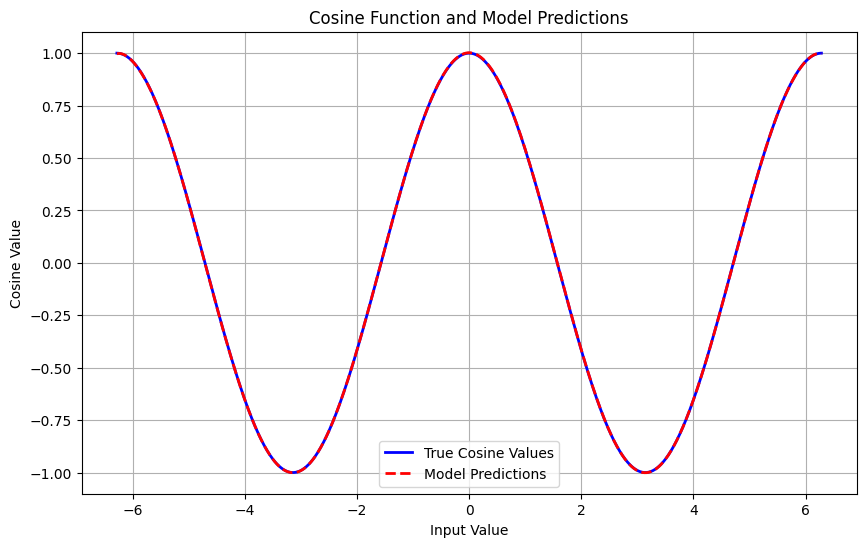

In [2]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(128,)(x)
    x = h2(x)
    x = Dense(128,)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128,)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64,)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 



input_shape = (1,)
filters = 64
model_bottleneck = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_bottleneck.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = model_bottleneck.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = model_bottleneck.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model_bottleneck.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



In [2]:
file_path = "X_array_best.csv"

# np.savetxt(file_path, X, delimiter=",")


Epoch 1/150


2023-10-05 14:28:14.233952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:28:14.251900: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


125/125 [==============================] - 1s 3ms/step - loss: 0.5052 - val_loss: 0.5042
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4968 - val_loss: 0.5045
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4971 - val_loss: 0.5213
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4979 - val_loss: 0.5043
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4975 - val_loss: 0.5046
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 0.5041 - val_loss: 0.5160
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4811 - val_loss: 0.5032
Epoch 8/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4868 - val_loss: 0.4131
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4329 - val_loss: 0.3762
Epoch 10/150
125/125 [==============================] - 0s 2ms/step - loss: 0.3309 - val_loss: 0.2736
E

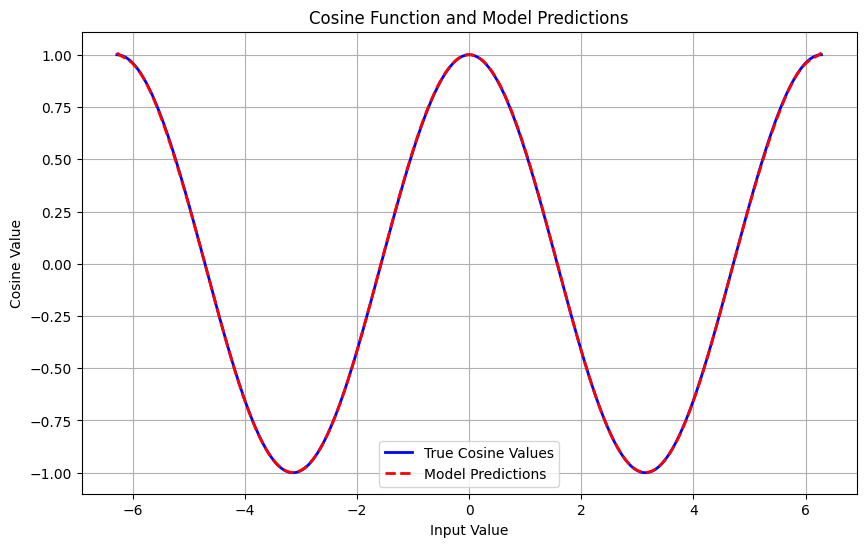

In [3]:
import pandas as pd
df = pd.read_csv(file_path)

X_1 = df.values  # This will convert the DataFrame to a NumPy array, assuming you have a single column in the CSV
y = np.cos(X_1)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_1, y, test_size=0.2)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(128,)(x)
    x = h2(x)
    x = Dense(128,)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(128,)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(64,)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
model_bottleneck_1 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_bottleneck_1.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = model_bottleneck_1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = model_bottleneck_1.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model_bottleneck_1.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

